# Digital PCR Simulation for Rare Mutation Detection

by: Luis Aguilera, November 19, 2025.

## Overview

Droplet digital PCR simulation for ultra-sensitive detection of KRAS mutations in circulating tumor DNA. Detection sensitivity down to 0.01% variant allele frequency using industry-standard Poisson statistical methods.



Poisson Statistics for Digital PCR

### Theoretical Foundation

Digital PCR quantification relies on **Poisson statistics** for absolute quantification:

$$\lambda = -\ln(1 - p)$$

Where:
- $\lambda$ = average number of target molecules per droplet
- $p$ = fraction of positive droplets ($\frac{\text{positive droplets}}{\text{total droplets}}$)

**Concentration calculation:**
$$\text{Copies/µL} = \frac{\lambda}{\text{droplet volume (µL)}}$$

**Poisson confidence intervals:** The 95% confidence interval for λ is calculated using Poisson distribution properties.

In [1]:
# Completed implementations
# ✓ Import libraries and configure plotting style
# ✓ Define DigitalPCRConfig with Bio-Rad QX200 specifications
# ✓ Implement Poisson lambda calculation with confidence intervals
# ✓ Create concentration converter (lambda → copies/µL)
# ✓ Build VAF calculator (mutant/(mutant+wildtype) × 100)
# ✓ Simulate droplet partitioning with Poisson distribution
# ✓ Generate realistic fluorescence signals (FAM/VIC channels)
# ✓ Model PCR efficiency (95%) and false positives (0.01%)
# ✓ Create 1D amplitude plots for channel-by-channel QC
# ✓ Implement LOD calculation using Rule of Three
# ✓ Run LOD analysis for 5K/10K/20K DNA inputs
# ✓ Simulate 5 VAF levels (5%, 1%, 0.5%, 0.1%, 0.01%)
# ✓ Calculate measured VAF with Poisson statistics

# Pending implementations
# ☐ Create 2D scatter plot with four-quadrant classification
# ☐ Generate formatted quantification report (pandas DataFrame)
# ☐ Export results to CSV/Excel for  documentation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pathlib import Path
from typing import Dict, Tuple
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [3]:
import yaml
from pathlib import Path

# Load Configuration
CONFIG_PATH = "../config/pipeline_config.yml"
with open(CONFIG_PATH, 'r') as f:
    pipeline_config = yaml.safe_load(f)
GENE_NAME = pipeline_config['variant_calling']['target_gene']['name']

class DigitalPCRConfig:
    """Configuration parameters for droplet digital PCR simulation based on Bio-Rad QX200/QX600 specifications."""
    # Droplet partitioning parameters
    N_DROPLETS = 20000  # Total droplets per well (Bio-Rad QX200 standard)
    DROPLET_VOLUME_NL = 0.85  # Volume per droplet in nanoliters
    REACTION_VOLUME_UL = 20.0  # Total PCR reaction volume in microliters
    # FAM channel (mutant detection)
    FAM_BASELINE = 1000  # Background fluorescence (no target)
    FAM_POSITIVE = 8000  # Signal fluorescence (target present)
    FAM_THRESHOLD = 3500  # Cutoff for positive droplet classification
    # VIC channel (wildtype detection)
    VIC_BASELINE = 1200  # Background fluorescence (no target)
    VIC_POSITIVE = 7500  # Signal fluorescence (target present)
    VIC_THRESHOLD = 3500  # Cutoff for positive droplet classification
    # Signal variability and assay performance
    SIGNAL_STD = 500  # Standard deviation of fluorescence signal
    PCR_EFFICIENCY = 0.95  # Probability of successful amplification (95%)
    FALSE_POSITIVE_RATE = 0.0001  # Background contamination rate (0.01%)
    # DNA quantification constants
    DNA_CONCENTRATION_NG_UL = 5.0  # Input DNA concentration (ng/µL)
    HUMAN_GENOME_SIZE_BP = 3.2e9  # Haploid human genome size (base pairs)
    AVG_BP_WEIGHT_DALTONS = 650  # Average molecular weight per base pair
    AVOGADRO = 6.022e23  # Avogadro's number (molecules/mole)

config = DigitalPCRConfig()
print(f"Target Gene: {GENE_NAME}")
print(f"Droplets per well: {config.N_DROPLETS:,}")
print(f"Droplet volume: {config.DROPLET_VOLUME_NL} nL")
print(f"PCR efficiency: {config.PCR_EFFICIENCY*100:.1f}%")

Droplets per well: 20,000
Droplet volume: 0.85 nL
PCR efficiency: 95.0%


In [4]:
def calculate_lambda_from_positives(n_positive: int, n_total: int) -> Tuple[float, float, float]:
    """Calculate lambda (copies per droplet) using Poisson statistics with 95% confidence intervals."""
    if n_positive == 0:
        return 0.0, 0.0, -np.log(1 - 0.95) / n_total
    if n_positive == n_total:
        return np.inf, np.inf, np.inf
    fraction_positive = n_positive / n_total
    lambda_estimate = -np.log(1 - fraction_positive)
    lower_positive = stats.poisson.ppf(0.025, n_positive) if n_positive > 0 else 0
    upper_positive = stats.poisson.ppf(0.975, n_positive + 1)
    lambda_lower = -np.log(1 - lower_positive / n_total) if lower_positive < n_total else 0
    lambda_upper = -np.log(1 - upper_positive / n_total) if upper_positive < n_total else np.inf
    return lambda_estimate, lambda_lower, lambda_upper

def calculate_concentration(lambda_value: float, droplet_volume_nl: float = config.DROPLET_VOLUME_NL) -> float:
    """Convert lambda to concentration in copies/µL."""
    droplet_volume_ul = droplet_volume_nl / 1000
    return lambda_value / droplet_volume_ul



In [5]:
def calculate_lod(n_droplets = config.N_DROPLETS, total_dna_copies= 10000, min_positive_droplets = 3):
    """Calculate theoretical Limit of Detection (LOD) for ddPCR assay using Rule of Three."""
    lambda_minimum, _, _ = calculate_lambda_from_positives(min_positive_droplets, n_droplets)
    min_detectable_copies = lambda_minimum * n_droplets
    lod_vaf = (min_detectable_copies / total_dna_copies) * 100
    lod_concentration = calculate_concentration(lambda_minimum)
    return {
        'lambda_min': lambda_minimum,
        'min_detectable_copies': min_detectable_copies,
        'lod_vaf_percent': lod_vaf,
        'lod_concentration_copies_per_ul': lod_concentration,
        'n_droplets': n_droplets,
        'min_positive_droplets': min_positive_droplets,
        'total_dna_input': total_dna_copies
    }

scenarios = [(20000, 5000, "5K copies"), (20000, 10000, "10K copies"), (20000, 20000, "20K copies")]
lod_results = []
print("\nLimit of Detection Analysis")
for n_drops, dna_input, description in scenarios:
    lod_dict = calculate_lod(n_droplets=n_drops, total_dna_copies=dna_input)
    lod_results.append(lod_dict)
    print(f"{description}: LOD = {lod_dict['lod_vaf_percent']:.4f}% VAF")


Limit of Detection Analysis
5K copies: LOD = 0.0600% VAF
10K copies: LOD = 0.0300% VAF
20K copies: LOD = 0.0150% VAF


In [6]:
def plot_amplitude(data_dict, title = None, figsize=(8, 4)):
    """
    Create dual 1D amplitude plots (FAM + VIC) side-by-side for quality control.
    Input: data_dict (Dict), title (str), figsize (Tuple[int, int])
    Output: Tuple[Figure, Axes] - matplotlib figure and axes objects
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    # --- LEFT PLOT: FAM Channel (Test - Mutant) ---
    ax_fam = axes[0]
    fluorescence_fam = data_dict['fam_fluorescence']
    positive_mask_fam = data_dict['fam_positive']
    threshold_fam = config.FAM_THRESHOLD
    n_positive_fam = data_dict['n_fam_only'] + data_dict['n_double_positive']
    n_negative_fam = np.sum(~positive_mask_fam)
    event_numbers = np.arange(len(fluorescence_fam))
    ax_fam.scatter(event_numbers[~positive_mask_fam], fluorescence_fam[~positive_mask_fam],
                  c='#808080', s=3, alpha=0.4, label=f'Negative ({n_negative_fam:,})',
                  edgecolors='none', rasterized=True)
    ax_fam.scatter(event_numbers[positive_mask_fam], fluorescence_fam[positive_mask_fam],
                  c='#1E88E5', s=3, alpha=0.5, label=f'Positive ({n_positive_fam:,})',
                  edgecolors='none', rasterized=True)
    ax_fam.axhline(y=threshold_fam, color='magenta', linestyle='-', linewidth=2,
                  label=f'Threshold ({threshold_fam})', alpha=0.8)
    ax_fam.set_xlabel('Event Number', fontsize=10, fontweight='bold')
    ax_fam.set_ylabel('FAM Amplitude (Mutant KRAS G12C)', fontsize=10, fontweight='bold')
    ax_fam.set_title(f'Ch1 FAM (Test) | Pos:{n_positive_fam} Neg:{n_negative_fam}',
                    fontsize=10, fontweight='bold', pad=12)
    ax_fam.set_xlim(0, len(fluorescence_fam))
    ax_fam.set_ylim(0, max(fluorescence_fam) * 1.1)
    ax_fam.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax_fam.legend(loc='upper right', framealpha=0.95, fontsize=9)
    # --- RIGHT PLOT: VIC Channel (Control - Wildtype) ---
    ax_vic = axes[1]
    fluorescence_vic = data_dict['vic_fluorescence']
    positive_mask_vic = data_dict['vic_positive']
    threshold_vic = config.VIC_THRESHOLD
    n_positive_vic = data_dict['n_vic_only'] + data_dict['n_double_positive']
    n_negative_vic = np.sum(~positive_mask_vic)
    ax_vic.scatter(event_numbers[~positive_mask_vic], fluorescence_vic[~positive_mask_vic],
                  c='#808080', s=3, alpha=0.4, label=f'Negative ({n_negative_vic:,})',
                  edgecolors='none', rasterized=True)
    ax_vic.scatter(event_numbers[positive_mask_vic], fluorescence_vic[positive_mask_vic],
                  c='#27AE60', s=3, alpha=0.5, label=f'Positive ({n_positive_vic:,})',
                  edgecolors='none', rasterized=True)
    ax_vic.axhline(y=threshold_vic, color='magenta', linestyle='-', linewidth=2,
                  label=f'Threshold ({threshold_vic})', alpha=0.8)
    ax_vic.set_xlabel('Event Number', fontsize=10, fontweight='bold')
    ax_vic.set_ylabel('VIC Amplitude (Wildtype KRAS)', fontsize=10, fontweight='bold')
    ax_vic.set_title(f'Ch2 VIC (Control) | Pos:{n_positive_vic} Neg:{n_negative_vic}',
                    fontsize=10, fontweight='bold', pad=12)
    ax_vic.set_xlim(0, len(fluorescence_vic))
    ax_vic.set_ylim(0, max(fluorescence_vic) * 1.1)
    ax_vic.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax_vic.legend(loc='upper right', framealpha=0.95, fontsize=9)
    # Overall title
    if title is None:
        title = f"Droplet DigitalPCR Quality Control | Input VAF: {data_dict['vaf_input']:.2f}%"
    fig.suptitle(title, fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes

In [7]:
def calculate_vaf(mutant_concentration: float, wildtype_concentration: float) -> float:
    """Calculate variant allele frequency as percentage: mutant / (mutant + wildtype) × 100."""
    total_concentration = mutant_concentration + wildtype_concentration
    if total_concentration == 0:
        return 0.0
    return (mutant_concentration / total_concentration) * 100


In [8]:
def simulate_droplet_partitioning(vaf_percent: float, total_dna_copies: int, 
                                 n_droplets: int = config.N_DROPLETS,
                                 pcr_efficiency: float = config.PCR_EFFICIENCY) -> Dict:
    """Simulate droplet digital PCR partitioning with Poisson distribution and fluorescence detection."""
    vaf_fraction = vaf_percent / 100
    mutant_copies = int(total_dna_copies * vaf_fraction)
    wildtype_copies = total_dna_copies - mutant_copies
    lambda_mutant = mutant_copies / n_droplets
    lambda_wildtype = wildtype_copies / n_droplets
    mutant_per_droplet = np.random.poisson(lambda_mutant, n_droplets)
    wildtype_per_droplet = np.random.poisson(lambda_wildtype, n_droplets)
    fam_fluorescence = np.zeros(n_droplets)
    vic_fluorescence = np.zeros(n_droplets)
    for i in range(n_droplets):
        if mutant_per_droplet[i] > 0 and np.random.random() < pcr_efficiency:
            fam_fluorescence[i] = np.random.normal(config.FAM_POSITIVE, config.SIGNAL_STD)
        else:
            fam_fluorescence[i] = np.random.normal(config.FAM_BASELINE, config.SIGNAL_STD * 0.3)
        if wildtype_per_droplet[i] > 0 and np.random.random() < pcr_efficiency:
            vic_fluorescence[i] = np.random.normal(config.VIC_POSITIVE, config.SIGNAL_STD)
        else:
            vic_fluorescence[i] = np.random.normal(config.VIC_BASELINE, config.SIGNAL_STD * 0.3)
    false_positive_mask = np.random.random(n_droplets) < config.FALSE_POSITIVE_RATE
    fam_fluorescence[false_positive_mask] = np.random.normal(
        config.FAM_POSITIVE * 0.6, config.SIGNAL_STD, np.sum(false_positive_mask))
    fam_positive = fam_fluorescence > config.FAM_THRESHOLD
    vic_positive = vic_fluorescence > config.VIC_THRESHOLD
    double_negative = ~fam_positive & ~vic_positive
    fam_only = fam_positive & ~vic_positive
    vic_only = ~fam_positive & vic_positive
    double_positive = fam_positive & vic_positive
    return {
        'vaf_input': vaf_percent,
        'mutant_copies_input': mutant_copies,
        'wildtype_copies_input': wildtype_copies,
        'total_copies_input': total_dna_copies,
        'lambda_mutant': lambda_mutant,
        'lambda_wildtype': lambda_wildtype,
        'fam_fluorescence': fam_fluorescence,
        'vic_fluorescence': vic_fluorescence,
        'fam_positive': fam_positive,
        'vic_positive': vic_positive,
        'double_negative': double_negative,
        'fam_only': fam_only,
        'vic_only': vic_only,
        'double_positive': double_positive,
        'n_droplets': n_droplets,
        'n_fam_only': np.sum(fam_only),
        'n_vic_only': np.sum(vic_only),
        'n_double_positive': np.sum(double_positive),
        'n_double_negative': np.sum(double_negative)
    }

In [9]:
# Simulating clinical VAF scenarios
vaf_levels = [5.0, 1.0, 0.5, 0.1, 0.01]
total_dna_copies = 10000
simulation_results = {}
for vaf in vaf_levels:
    data_dict = simulate_droplet_partitioning(vaf, total_dna_copies)
    lambda_mut, lambda_mut_low, lambda_mut_high = calculate_lambda_from_positives(
        data_dict['n_fam_only'] + data_dict['n_double_positive'], data_dict['n_droplets'])
    lambda_wt, lambda_wt_low, lambda_wt_high = calculate_lambda_from_positives(
        data_dict['n_vic_only'] + data_dict['n_double_positive'], data_dict['n_droplets'])
    mutant_concentration = calculate_concentration(lambda_mut)
    wildtype_concentration = calculate_concentration(lambda_wt)
    vaf_measured = calculate_vaf(mutant_concentration, wildtype_concentration)
    data_dict['lambda_mutant_measured'] = lambda_mut
    data_dict['lambda_wildtype_measured'] = lambda_wt
    data_dict['mutant_conc_measured'] = mutant_concentration
    data_dict['wildtype_conc_measured'] = wildtype_concentration
    data_dict['vaf_measured'] = vaf_measured
    simulation_results[vaf] = data_dict

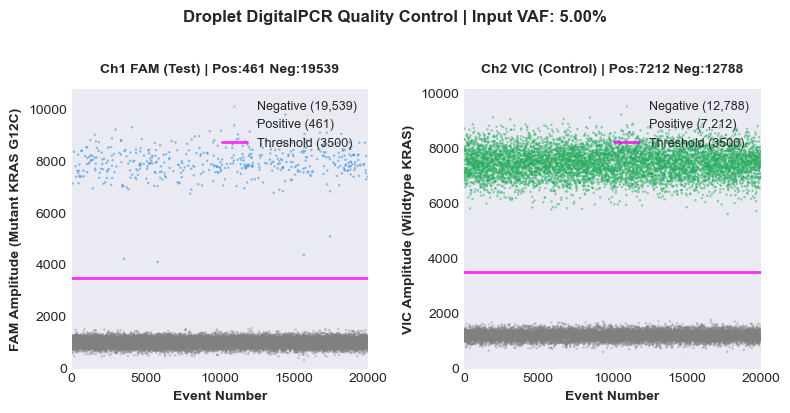

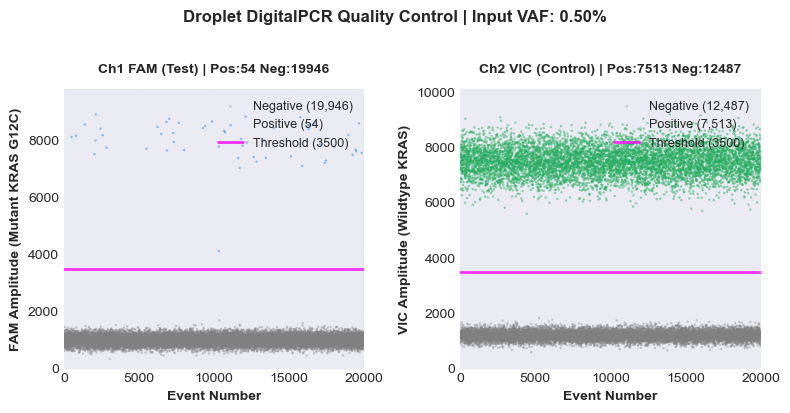

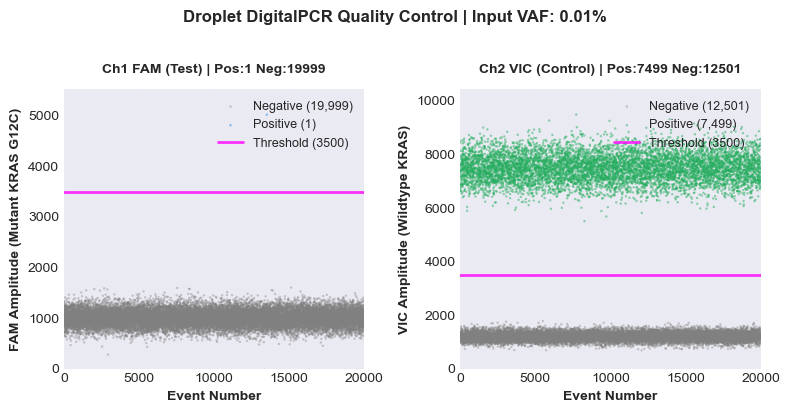

In [11]:
# Plotting for multiple VAFs with dual horizontal subplots
os.makedirs('ddpcr_plots', exist_ok=True)
for vaf in [5.0, 0.5, 0.01]:
    data_dict = simulation_results[vaf]
    fig, axes = plot_amplitude(data_dict)
    plt.show()

Figure saved: ddpcr_plots/ddpcr_publication_vaf_5.0.png


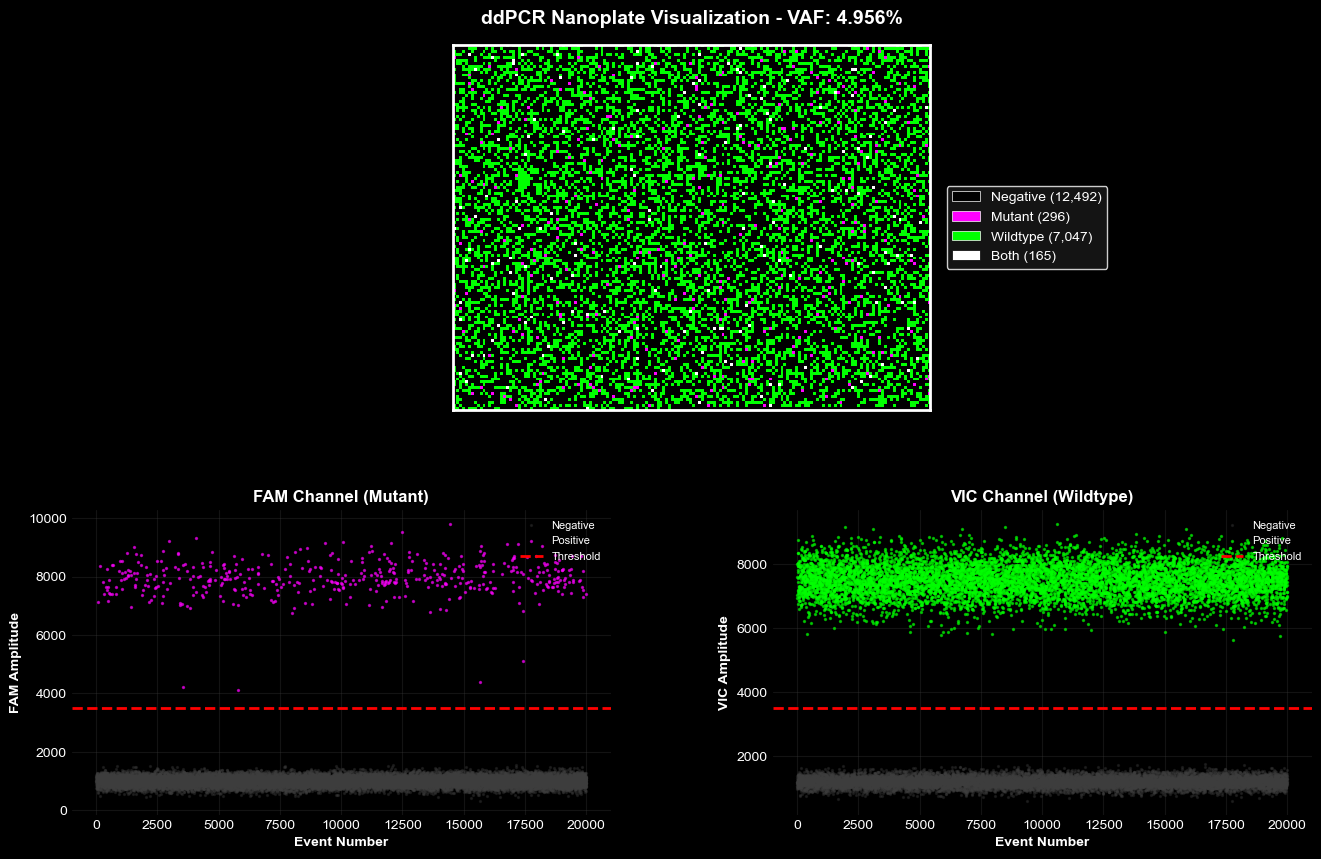

Saved publication figure for VAF 5.0%
Figure saved: ddpcr_plots/ddpcr_publication_vaf_0.5.png


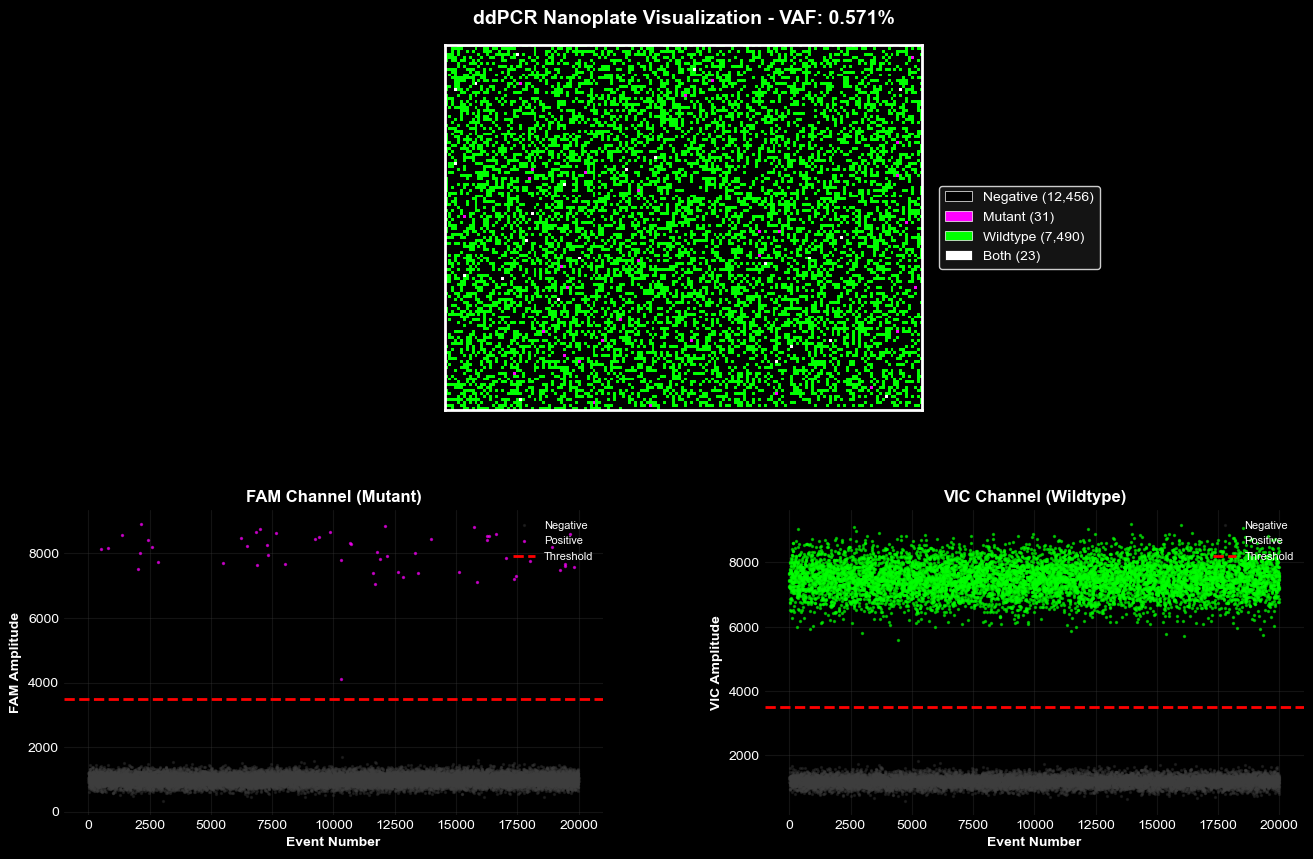

Saved publication figure for VAF 0.5%
Figure saved: ddpcr_plots/ddpcr_publication_vaf_0.01.png


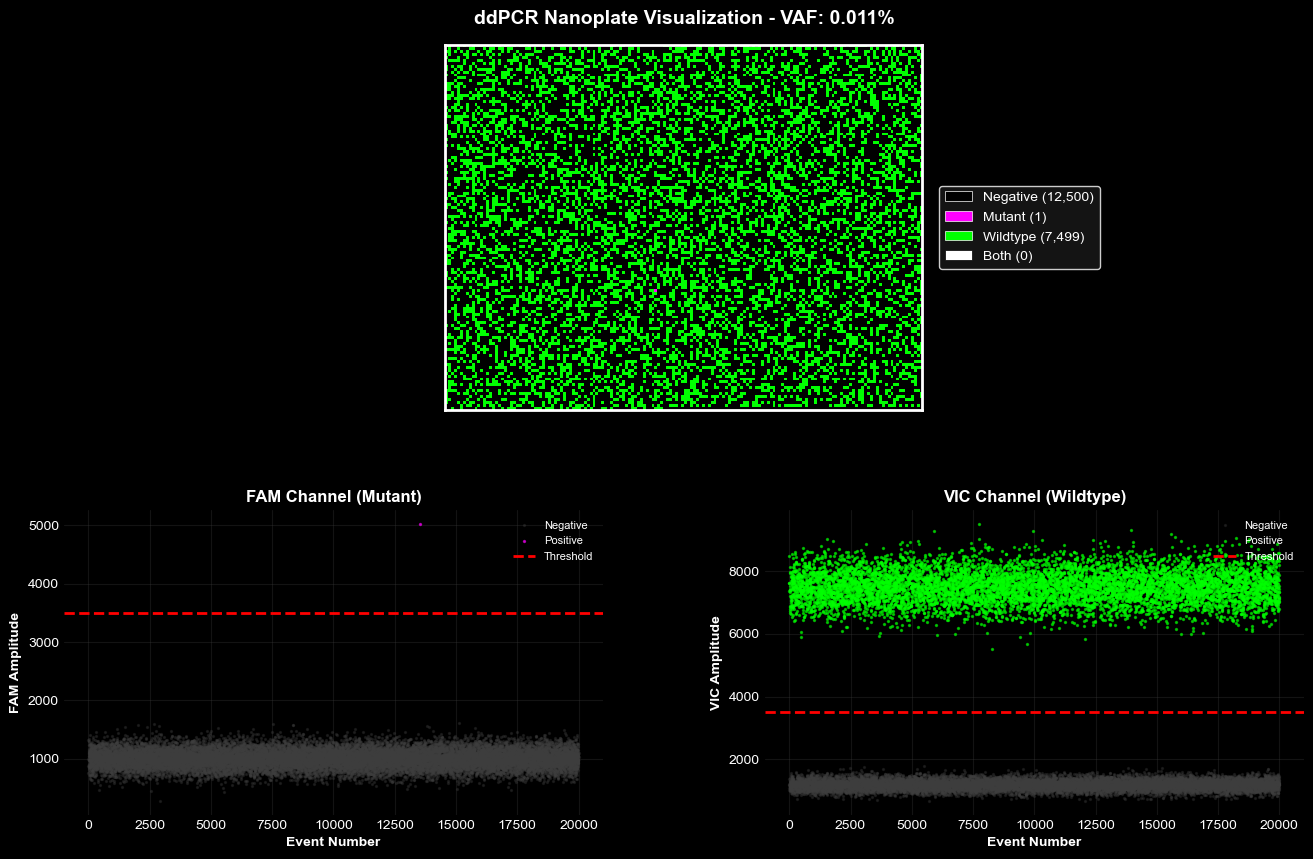

Saved publication figure for VAF 0.01%


In [13]:
# Import nanoplate visualization
from dpcr_nanoplate_visualization import NanoplateVisualizer, create_publication_figure

# Initialize visualizer
visualizer = NanoplateVisualizer(n_droplets=config.N_DROPLETS)

os.makedirs('ddpcr_plots', exist_ok=True)
for vaf in [5.0, 0.5, 0.01]:
    data_dict = simulation_results[vaf]
    # Combined nanoplate + amplitude plots
    fig, axes = create_publication_figure(
        data_dict,
        output_path=f'ddpcr_plots/ddpcr_publication_vaf_{vaf}.png'
    )
    plt.show()
    print(f"Saved publication figure for VAF {vaf}%")
